Warning: This notebook may take several hours to produce the result. Please be careful if you need to replicate the results.

In [1]:
#Import core modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#Import logit regression modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
#Import random forest modules
from sklearn.ensemble import RandomForestClassifier
#Import support vector machine modules
from sklearn import svm
#Import neural network modules
from sklearn.neural_network import MLPClassifier

In [2]:
#Import data
src = pd.read_csv('strongdrink.txt', sep = ',')
src.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
X = src[['alco', 'malic', 'tot_phen', 'color_int']].values
y = src['cultivar'].values

## (a) Scatterplot

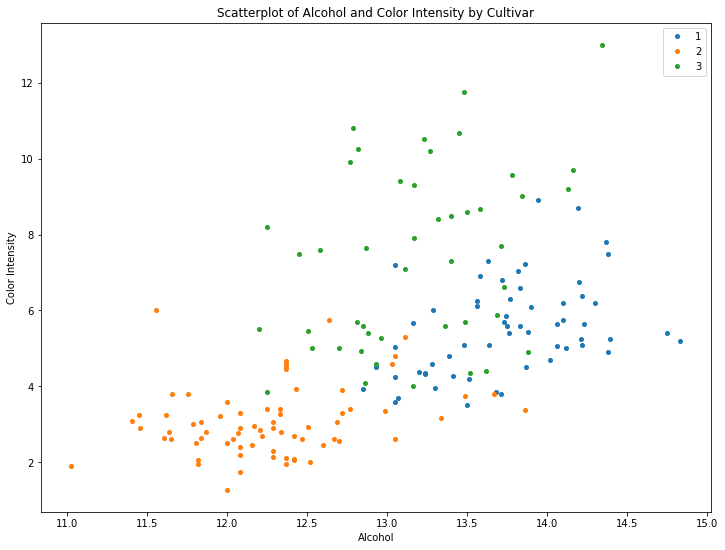

In [4]:
groups = src.groupby('cultivar')

fig, ax = plt.subplots(figsize=(12,9))
for name, group in groups:
    ax.plot(group['alco'], group['color_int'], marker='o', linestyle='', ms=4, label=name)
ax.legend()
plt.xlabel('Alcohol')
plt.ylabel('Color Intensity')
plt.title('Scatterplot of Alcohol and Color Intensity by Cultivar')
plt.show()

## (b) Logistic Regression with K-fold Cross Validation

In scikit learn, most solvers of logistic regression do not allow 'l1' penalty except the `'saga'` solver.
See http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html.

Considering there is no requirement (in the Problem Set) to adjust our solver to 'saga', and the fact 'saga' solver will yield a non-convergent result with default maximum iterations, I decide to offer two solutions to this part:

(1) Logistic regression with the `'newton-cg'` solver with different `C` parameter (and default maximum iterations).
(2) Logistic regression with the `'saga'` solver with different `penalty` (`l1` or `l2`) and `C` parameter, as well as the default maximum iterations set to 10000 (100 times the default value).

In either cases, the `C` parameters would take values from 0.01 to 1. `C` parameters above 1.0 is acceptable, but not needed, since the `C` parameter is only needed when we want to reduce overfitting. For more information, check this thread: https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul.

In [5]:
k = 4
clf_mlog = KFold(n_splits=4, shuffle=True, random_state=22)
clf_mlog.get_n_splits(X)
MSE = np.zeros(k)
C = np.zeros(100)
MSE_newton = np.zeros(100)

### (b1) with `newton-cg` solver

In [6]:
for index in range(100):
    c = (index+1)/100
    #Begin the K-fold process
    k_ind = int(0)
    for train_index, test_index in clf_mlog.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        LogReg = LogisticRegression(multi_class='multinomial', fit_intercept = True,
                                    solver='newton-cg', C = c)
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        error = y_test != y_pred
        MSE[k_ind] = error.mean()
        k_ind += 1
    C[index] = c
    MSE_newton[index] =  MSE.mean()
MSE_logit_newton = pd.DataFrame({'C':C, 'MSE':MSE_newton})
MSE_logit_newton.sort_values(['MSE']).head(25)

,C,MSE
36,0.37,0.068182
29,0.30,0.068182
30,0.31,0.068182
31,0.32,0.068182
32,0.33,0.068182
33,0.34,0.068182
34,0.35,0.068182
35,0.36,0.068182
37,0.38,0.068182
38,0.39,0.068182


<span style="color:blue">
b1) Conclusion: With `newton-cg` solver, the lowest MSE is achieved when `C` takes the values **0.28-0.44** ('l2' penalty by default).
</span>

### (b2) with `saga` solver 

##### Warning: This part is going to take some time!

In [7]:
MSE_saga = np.zeros(100)
penalty = np.full((100,), 'l1')
for index in range(100):
    c = (index+1)/100
    #Begin the K-fold process
    k_ind = int(0)
    for train_index, test_index in clf_mlog.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        LogReg = LogisticRegression(multi_class='multinomial', fit_intercept = True,
                                    solver='saga', penalty='l1', max_iter=10000, C=c)
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        error = y_test != y_pred
        MSE[k_ind] = error.mean()
        k_ind += 1
    C[index] = c
    MSE_saga[index] =  MSE.mean()
MSE_logit_l1 = pd.DataFrame({'C':C, 'MSE':MSE_saga, 'penalty':penalty})

In [8]:
penalty = np.full((100,), 'l2')
for index in range(100):
    c = (index+1)/100
    #Begin the K-fold process
    k_ind = int(0)
    for train_index, test_index in clf_mlog.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        LogReg = LogisticRegression(multi_class='multinomial', fit_intercept = True,
                                    solver='saga', penalty='l2', max_iter=10000, C=c)
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        error = y_test != y_pred
        MSE[k_ind] = error.mean()
        k_ind += 1
    C[index] = c
    MSE_saga[index] =  MSE.mean()
MSE_logit_l2 = pd.DataFrame({'C':C, 'MSE':MSE_saga, 'penalty':penalty})
MSE_logit = MSE_logit_l1.append(MSE_logit_l2)

In [9]:
MSE_logit.sort_values(['MSE']).head(25)

,C,MSE,penalty
75,0.76,0.079545,l2
69,0.70,0.085227,l2
39,0.40,0.085227,l2
38,0.39,0.085227,l2
37,0.38,0.085227,l2
36,0.37,0.085227,l2
35,0.36,0.085227,l2
34,0.35,0.085227,l2
68,0.69,0.085227,l2
32,0.33,0.085227,l2


We know that the smallest value is 0.079545. Therefore we can subset:

<span style="color:blue">
b2) Conclusion: With `saga` solver, the lowest MSE is achieved when **penalty** takes 'l2' and **C** takes 0.54, which takes a value of 0.079545.
</span>

## c) Random Forest Classifier

The scheme for this test is stated as follows:
    
    'n_estimator' will take values from 10 to 200, with an increment of 5. Usually we believe the more trees the better, but considering that we only have 176 observations, a maximum of 200 is a reasonable number.
    
    'min_samples_leaf' will take values from 1 to 10 (with an increment of 1). The reason is that our sample has only 176 observations, setting a large threshold is likely to eliminate some interesting classifications.
    
    'max_depth' will take values from 1 to 15, with an increment of 1.   

##### Warning: This part is going to take some time!

In [10]:
MSE_LOOP = pd.DataFrame({'n_estimator' : np.zeros(39),
                        'min_samples_leaf' : np.zeros(39),
                        'max_depth' : np.zeros(39),
                        'MSE' : np.zeros(39)})
MSE_RF = MSE_LOOP[:0]


for msl in range(10):
    for md in range(15):
        for tree in range(39):
            RF = RandomForestClassifier(n_estimators = (tree * 5 + 10),
                                        min_samples_leaf = (msl + 1),
                                        max_depth = (md + 1), bootstrap=True, 
                                        oob_score=True, random_state=22)
            RF.fit(X, y)
            MSE_LOOP["n_estimator"][tree] = tree * 5 + 10
            MSE_LOOP["max_depth"][tree] = md + 1
            MSE_LOOP["min_samples_leaf"][tree] = msl + 1
            MSE_LOOP["MSE"][tree] = 1 - RF.oob_score_
        MSE_RF = pd.concat([MSE_RF, MSE_LOOP])

In [11]:
MSE_RF.index = range(len(MSE_RF))
MSE_RF.sort_values(['MSE']).head()

,MSE,max_depth,min_samples_leaf,n_estimator
757,0.056818,5.0,2.0,90.0
759,0.056818,5.0,2.0,100.0
758,0.056818,5.0,2.0,95.0
830,0.056818,7.0,2.0,65.0
1071,0.056818,13.0,2.0,100.0


We get the minimum value of the MSE is 0.056818.

In [12]:
MSE_RF[MSE_RF['MSE'] < 0.056819]

,MSE,max_depth,min_samples_leaf,n_estimator
315,0.056818,9.0,1.0,25.0
354,0.056818,10.0,1.0,25.0
393,0.056818,11.0,1.0,25.0
432,0.056818,12.0,1.0,25.0
471,0.056818,13.0,1.0,25.0
510,0.056818,14.0,1.0,25.0
549,0.056818,15.0,1.0,25.0
752,0.056818,5.0,2.0,65.0
753,0.056818,5.0,2.0,70.0
756,0.056818,5.0,2.0,85.0


<span style="color:blue">
c) Conclusion: The Random Forest Classifier yields the lowest MSE in the following situation (64 cases):
</span>

<span style="color:#8a2be2">
(1) `min_samples_leaf` must be less than 3 (**1** or **2**).
</span>

<span style="color:#8a2be2">
(2) `n_estimator` takes the value **25** when `min_samples_leaf` takes the value 1.
    It takes the value *65, 85, 90, 95, 100* (generally larger than **60** but no more than **100**) when min_samples_leaf takes the value 2. Confirming our guess the larger `n_estimator` yield better fitting. However, an extremely large `n_estimator` may not (for example values over 100).
</span>

<span style="color:#8a2be2">
(3) `max_depth` takes the values **9-15** when `min_samples_leaf` takes the value 1, with `n_estimator` equal to 25.
    It takes the value **5-15** when `min_samples_leaf` takes the value 2.

## d) Support Vector Classifier

The scheme for this test is stated as follows:

    C takes the values of 2**(-5), 2**(-3), ..., 2**15
    
    Gamma takes the values of 2**(-15), 2**(-13), ..., 2**3
 
For more explanation on the exponential scheme, please check the following thread and document:\

Thread: https://stats.stackexchange.com/questions/43943/which-search-range-for-determining-svm-optimal-c-and-gamma-parameters
    
Document: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

In [13]:
k = 4
clf_svm = KFold(n_splits=4, shuffle=True, random_state=22)
clf_svm.get_n_splits(X)
MSE = np.zeros(k)
MSE_SVC = pd.DataFrame({"Cost" : np.zeros(10),
                        "Gamma" : np.zeros(10),
                        "MSE" : np.zeros(10)})
MSE_SVM = MSE_SVC[:0]

In [14]:
for c in range(11):
    for g in range(10):
        k_ind = int(0)
        for train_index, test_index in clf_svm.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            svc = svm.SVC(kernel='rbf', gamma = 2**(-15+2*g),
                          C= 2**(-5+2*c))
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            error = y_test != y_pred
            MSE[k_ind] = error.mean()
            k_ind += 1
        MSE_SVC['Cost'][g] = 2**(-5+2*c)
        MSE_SVC['Gamma'][g] = 2**(-15+2*g)
        MSE_SVC['MSE'][g] =  MSE.mean()
    MSE_SVM = pd.concat([MSE_SVM, MSE_SVC])

In [15]:
MSE_SVM.index = range(len(MSE_SVM))
MSE_SVM.sort_values(['MSE']).head()

,Cost,Gamma,MSE
36,2.0,0.125000,0.056818
38,2.0,2.000000,0.068182
46,8.0,0.125000,0.068182
64,128.0,0.007812,0.068182
73,512.0,0.001953,0.073864


<span style="color:blue">
d) Conclusion: The Support Vector Classifier yields the lowest MSE `(0.568)` in the following situation when `cost` = 2\*\*1 `(2)` and `Gamma` = 2\*\*(-3) `(0.125)`.
</span>

### e) MLP neural network

The scheme for this test is stated as follows:

    'activation' takes the values of 'identity', 'logistic', 'tanh', 'relu'
    
    'alpha' takes the values 0.01-1.00, with an increment of 0.01.
    
    'hidden_layer_size' takes the values 

In [16]:
k = 4
clf_mlp = KFold(n_splits=k, random_state=22, shuffle=True)
clf_mlp.get_n_splits(X)
MSE = np.zeros(k)
activ = np.array(['identity', 'logistic', 'tanh', 'relu'])
MSE_al = pd.DataFrame({'activation' : np.zeros(100),
                       'hidden layer' : np.zeros(100),
                       'alpha' : np.zeros(100),
                       'MSE':np.zeros(100)})
MSE_mlp = MSE_al[:0]

##### Warning: This part is going to take some time! It took me over 90 minutes to run these results.

In [17]:
for ac in activ:
    for h in np.linspace(1,201,21):
        for i, al in enumerate(np.linspace(0.01,1,100)):
            k_ind = int(0)
            for train_index, test_index in clf_mlp.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                mlp = MLPClassifier(activation=ac, solver='lbfgs',
                                    alpha=al, random_state=25,
                                    hidden_layer_sizes = ((int(h)),))
                mlp.fit(X_train, y_train)
                y_pred = mlp.predict(X_test)
                error = y_test != y_pred
                MSE[k_ind] = error.mean()
                k_ind += 1
            MSE_al.loc[i,'activation'] = ac
            MSE_al.loc[i,'hidden layer'] = h
            MSE_al.loc[i,'alpha'] = al
            MSE_al.loc[i,'MSE'] =  MSE.mean()
        MSE_mlp = pd.concat([MSE_mlp, MSE_al])

In [18]:
MSE_mlp.index = range(len(MSE_mlp))
MSE_mlp.sort_values(['MSE']).head(25)

,MSE,activation,alpha,hidden layer
6721,0.034091,relu,0.22,41.0
7648,0.034091,relu,0.49,131.0
8123,0.034091,relu,0.24,181.0
7518,0.034091,relu,0.19,121.0
7528,0.034091,relu,0.29,121.0
6681,0.034091,relu,0.82,31.0
7476,0.039773,relu,0.77,111.0
7513,0.039773,relu,0.14,121.0
7011,0.039773,relu,0.12,71.0
6757,0.039773,relu,0.58,41.0


<span style="color:blue">
e) Conclusion: The MLP yields the lowest MSE `(0.0398)` whenWhen `activation` = 'relu'. There is no clear cutting area of `alpha` and `hidden layers`.
</span>

## (f) Comparison

Scheme:
    
    In this part, I am going to take the top five unique (not duplicate) MSE of each method.

In [19]:
top_logit_newton = MSE_logit_newton.sort_values(['MSE'])['MSE'].unique()[:5]
top_logit = MSE_logit.sort_values(['MSE'])['MSE'].unique()[:5]
top_RF = MSE_RF.sort_values(['MSE'])['MSE'].unique()[:5]
top_SVM = MSE_SVM.sort_values(['MSE'])['MSE'].unique()[:5]
top_mlp = MSE_mlp.sort_values(['MSE'])['MSE'].unique()[:5]
rank = ['1', '2', '3', '4', '5']

Com = pd.DataFrame({'Logit_newton':top_logit_newton,
                    'Logit_saga':top_logit,
                    'RF':top_RF,
                    'SVM':top_SVM,
                    'MLP':top_mlp,
                    'rank':rank})
Com

,Logit_newton,Logit_saga,MLP,RF,SVM,rank
0,0.068182,0.079545,0.034091,0.056818,0.056818,1
1,0.073864,0.085227,0.039773,0.062500,0.068182,2
2,0.079545,0.085227,0.045455,0.068182,0.073864,3
3,0.085227,0.090909,0.051136,0.073864,0.079545,4
4,0.090909,0.096591,0.051136,0.079545,0.085227,5


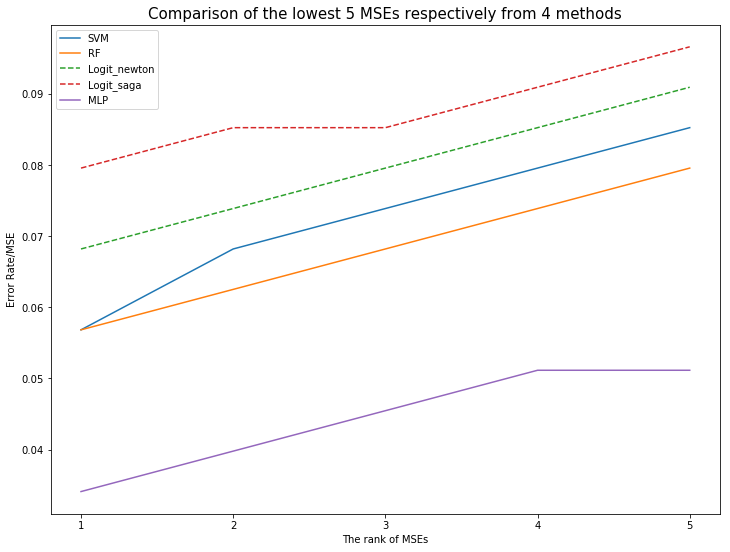

In [20]:
plt.figure(figsize=(12,9))
plt.plot(Com['rank'], Com['SVM'], label='SVM')
plt.plot(Com['rank'], Com['RF'], label='RF')
plt.plot(Com['rank'], Com['Logit_newton'], label='Logit_newton', ls =  'dashed')
plt.plot(Com['rank'], Com['Logit_saga'], label='Logit_saga', ls =  'dashed')
plt.plot(Com['rank'], Com['MLP'], label='MLP')
plt.legend(loc='best')
plt.title('Comparison of the lowest 5 MSEs respectively from 4 methods', fontsize = 15)
plt.xlabel('The rank of MSEs')
plt.xticks(np.arange(1,6))
plt.ylabel("Error Rate/MSE")

<span style="color:blue">
f) Conclusion: The nerual network MLP method always yields the better predictions (lower MSEs) among the four methods. Considering we are taking unique values of the MSE statistics of the four methods, it is fair to claim that MLP is robustly better than the other three methods.
</span>

<span style="color:blue">
When considering the methods generating mediocre MSEs, we should always remind ourselves that logit and SVMs go through the K-folds cross-validation, which theoretically will yield no better statistics than bootstrapping (used by the random forest classifier).
</span>